In [2]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
from scipy import interpolate
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os

In [52]:
# Data load and pre-processing
version = 'v20221104'
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\May22_full_precompute\\"

file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing - version ' + version)
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

# Match tracks in the star pattern from track names and times in the DAR_v6.0 to file aquisition times
star_pattern_tracks={
    'Track_L1' : 0,
    'Track_1a' : 1,
    'Track_2a' : 2,
    'Track_1b' : 3,
    'Track_11' : 4,
    'Track_12' : 5,
    'Track_13' : 6,
    'Track_14' : 7,
    'Track_15' : 8,
    'Track_16' : 9,
    'Track_17' : 10,
    'Track_18' : 11}

# Compute L1C - Sigma0 + RVL
dsl1 = dict()
#for track in star_pattern_tracks.keys(): # Loop through star pattern tracks
for track in ['Track_13']:


    file_index = star_pattern_tracks[track]
    ds = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
    antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(oscar_path, file_time_triplets[file_index][1])

    ds = ss.oscar.level1.fill_missing_variables(ds, antenna_ident)
    #ds = fill_missing_variables(ds, antenna_ident)
    print('Processing file index',file_index)
    #L1 processing
    for i in list(ds.keys()):
        ds[i] = ss.oscar.level1.check_antenna_polarization(ds[i])
        ds[i] = ss.oscar.level1.compute_multilooking_Master_Slave(ds[i], window=7)
        ds[i]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
        ds[i] = ss.oscar.level1.compute_antenna_azimuth_direction(ds[i], antenna=antenna_ident[list(ds.keys()).index(i)])
        ds[i] = ss.oscar.level1.compute_time_lag_Master_Slave(ds[i], options='from_SAR_time')
        ds[i] = ss.oscar.level1.compute_radial_surface_velocity(ds[i])
    #Build L1 dataset
    dsl1[track] = ss.oscar.level1.merge_beams(ds, antenna_ident)


OSCAR L1 processing - version v20221104
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\May22_full_precompute\
-------------------
File index : 0 , Aquisition time : 20220522T052218 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220522T053942 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220522T054805 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220522T055458 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220522T062018 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220522T062620 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220522T063239 , File list indices : [18, 19, 20]
File index : 7 , Aquisition time : 20220522T063906 , File list indices : [21, 22, 23]
File index : 8 , Aquisition time : 20220522T064459 , File list indices : [24, 25, 26]
File index : 9 , Aquisition time : 20220522T065108 , File list indices :

<xarray.DataArray 'Dummy' (Antenna: 3)>
array([-9999, -9999, -9999])
Coordinates:
  * Antenna  (Antenna) <U4 'Mid' 'Fore' 'Aft'
Attributes:
    long_name:  Dummy value
    units:      []

In [62]:
for var in dsl1['Track_13'].data_vars:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        bad_val = dsl1['Track_13'][var].data == -9999
        if np.sum(bad_val) > 0:
            print(var)
            if var != 'Dummy' :
                dsl1['Track_13'][var].data[bad_val] = np.NaN

Dummy


In [55]:
def remove_dummy_values(ds, dummy_val=-9999):
    for var in ds.data_vars:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        bad_val = ds[var].data == dummy_val
        if np.sum(bad_val) > 0:
            print(var)
            if var != 'Dummy' :
                ds[var].data[bad_val][x] = np.NaN
    
    return ds

ValueError: cannot convert float NaN to integer

In [60]:
var != 'Dummy'

False

In [ ]:
def merge_beams(ds_dict, antenna_id):
    
    fore_id = list(ds_dict.keys())[antenna_id.index('Fore')]
    mid_id = list(ds_dict.keys())[antenna_id.index('Mid')]
    aft_id = list(ds_dict.keys())[antenna_id.index('Aft')]
    
    ds_level1 = xr.concat([ds.get(key) for key in [fore_id, aft_id]],
                          'AntennaSquint', join='outer',
                          coords='all')
    ds_level1 = ds_level1.assign_coords(AntennaSquint=('AntennaSquint', [fore_id, aft_id]))
    
    
    
    key_list = list(ds_dict.keys())
    ds_level1.coords['latitude'] = xr.merge(
            [ds_dict[key_list[0]].LatImage.dropna(dim='CrossRange'),
             ds_dict[key_list[1]].LatImage.dropna(dim='CrossRange'),
             ds_dict[key_list[2]].LatImage.dropna(dim='CrossRange')],
            ).LatImage
    ds_level1.coords['longitude'] = xr.merge(
            [ds_dict[key_list[0]].LonImage.dropna(dim='CrossRange'),
             ds_dict[key_list[1]].LonImage.dropna(dim='CrossRange'),
             ds_dict[key_list[2]].LonImage.dropna(dim='CrossRange')],
            ).LonImage

    return ds_level1

In [3]:
def fill_missing_variables(ds_dict, antenna_id):
    fore_id = list(ds_dict.keys())[antenna_id.index('Fore')]
    mid_id = list(ds_dict.keys())[antenna_id.index('Mid')]
    aft_id = list(ds_dict.keys())[antenna_id.index('Aft')]
    for var in ds_dict[fore_id].data_vars:
        if var not in ds_dict[mid_id].data_vars:
            if 'Slave' in var:
                var_master = var.replace('Slave','')
                ds_dict[mid_id][var] = xr.DataArray(data=np.full(ds_dict[mid_id][var_master].shape, np.NaN),
                                          coords=ds_dict[mid_id][var_master].coords,
                                              dims=ds_dict[mid_id][var_master].dims)
    # Find vars that dont exist in Fore, but exist in Mid
    ds_diff = ds_dict[mid_id]\
        [[x for x in ds_dict[mid_id].data_vars if x not in ds_dict[fore_id].data_vars]]
    ds_diff.where(ds_diff == np.nan, other=np.nan)
    ds_dict[fore_id] = ds_dict[fore_id].merge(ds_diff)

    # Find vars that dont exist in Aft, but exist in Mid
    ds_diff = ds_dict[mid_id]\
        [[x for x in ds_dict[mid_id].data_vars if x not in ds_dict[aft_id].data_vars]]
    ds_diff.where(ds_diff == np.nan, other=np.nan)
    ds_dict[aft_id] = ds_dict[aft_id].merge(ds_diff)
    #for var in ds[mid_id].data_vars:
    #    if var not in ds[fore_id].data_vars:
    #        ds_dict[fore_id][var] = xr.DataArray(data=np.full(ds_dict[mid_id][var].shape, np.NaN),
    #                                      coords=ds_dict[mid_id][var].coords,
    #                                          dims=ds_dict[mid_id][var].dims)
    #    if var not in ds[aft_id].data_vars:
    #        ds_dict[aft_id][var] = xr.DataArray(data=np.full(ds_dict[mid_id][var].shape, np.NaN),
    #                                      coords=ds_dict[mid_id][var].coords,
    #                                          dims=ds_dict[mid_id][var].dims)
    return ds_dict

In [ ]:
for var in ds[mid_id].data_vars:
    if var not in ds[fore_id].data_vars:
        print(var)

In [ ]:
ds[mid_id].CalImage

In [ ]:
np.full(ds[fore_id]['SigmaImageSingleLookRealPartSlave'].shape, np.NaN)

In [ ]:
ds[fore_id]

In [ ]:
ds[mid_id]

In [ ]:
ax1 = ds[mid_id].SigmaImageSingleLookRealPart.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='coolwarm',

                      )
ax2 = ds[mid_id].SigmaImageSingleLookRealPartSlave.plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='coolwarm',
                      )

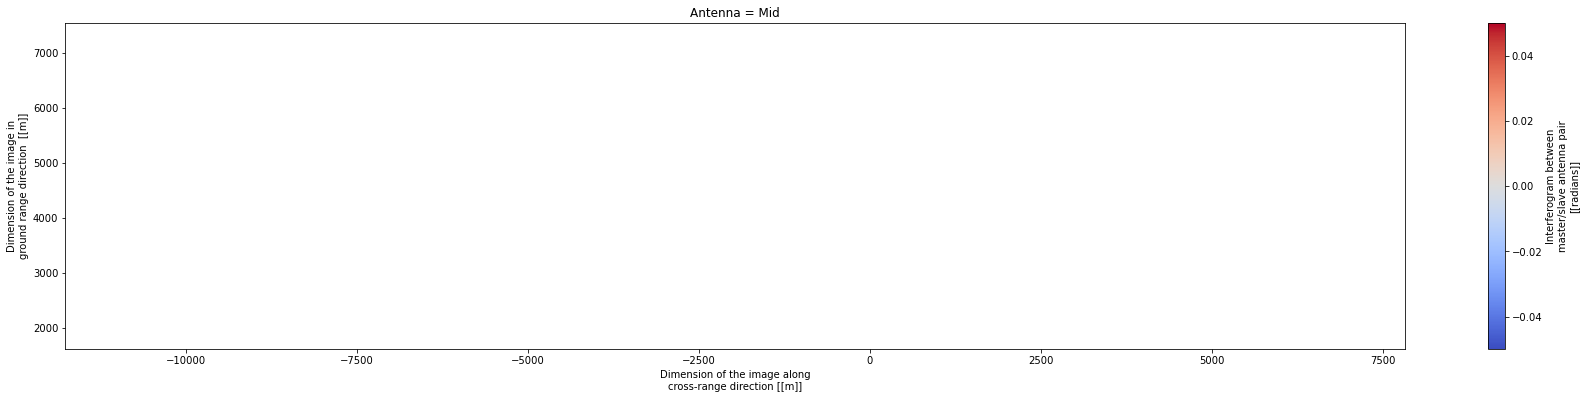

In [10]:
ax2 = dsl1['Track_13'].Interferogram.sel(Antenna='Mid').plot(figsize=(30, 6),
                        y='GroundRange', x='CrossRange',
                        robust=True,
                        cmap='coolwarm',

                      )

In [ ]:
ds[mid_id].SigmaImageSingleLookRealPartSlave.sel(CrossRange=0).plot(x='GroundRange')